# Estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. We will take the sensitivities to the factors to be time dependent, with the following shapes:
- A random smooth stationary series.
- A smooth increase, then decrease.
- A step function from 0 to 1. 
The factors themselves will be stationary time series. For now we take them to be random white noise. We could also take them to be smooth functions. In addition there is idiosynchratic component to the returns, which is a white noise too.

## Making the study rigorous

We need to:
- Rewrite the whole code in the form of a unique function that creates the samples, performes the rolling regression and Kalman estimations, and returns all the performance metrics.
- Then we should run this function a lot of times to gather statistics on the performance.
- We should think carefully about what kind of statistical test we can make to decide whether the performance of one method is significantly superior.
- We could add more factor shapes.
- We could use non-gaussian noise.
- We could vary the intensity of the noise (but this will require to reestimate the windo of the rolling regression and the covariances of the Kalman filters.


In [1139]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter

In [1205]:
# Helper functions
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
performance_record_mse = {}
performance_record_wacc = {}

def plot_estimated_sensitivities(sens, est_sens, colors):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    axc = ax[0,0]
    axc.plot(est_sens.iloc[:,0], c=colors[0])
    axc.plot(sens.iloc[:,0], '--', c='k')
    axc = ax[0,1]
    axc.plot(est_sens.iloc[:,1], c=colors[1])
    axc.plot(sens.iloc[:,1], '--', c='k')
    axc = ax[1,0]
    axc.plot(est_sens.iloc[:,2], c=colors[2])
    axc.plot(sens.iloc[:,2], '--', c='k')
    
def compute_estimated_returns(factors, est_sens):
    return pd.Series(np.multiply(factors, est_sens).sum(axis=1))

def plot_residuals(estimated_returns, returns):
    residuals = estimated_returns - returns
    plt.scatter(residuals.index, residuals, s=0.5)
    
def print_mse_performance(estimated_returns, returns, name, performance_record_mse, verbose=True):
    square_errors = np.square(estimated_returns - returns)
    mean_square_error = square_errors.sum()/len(estimated_returns)
    performance_record_mse[name] = mean_square_error
    if verbose:
        print(f"MSE for {name}, assuming the factors known: {mean_square_error}")
    
def print_weighted_accuracy_performance(estimated_returns, returns, name, performance_record_wacc, verbose=True):
    weights = abs(returns)
    correct_sign = -2*np.logical_xor(estimated_returns > 0, returns > 0) + 1
    weighted_accuracy = np.multiply(weights, correct_sign).mean()
    performance_record_wacc[name] = weighted_accuracy
    if verbose:
        print(f"Weighted accuracy for {name}, assuming the factors known: {weighted_accuracy}")
    
def plot_prediction_performance(factors, returns, est_sens, name):
    estimated_returns = compute_estimated_returns(factors, est_sens)
    print_mse_performance(estimated_returns, returns, name)
    print_weighted_accuracy_performance(estimated_returns, returns, name)
    plot_residuals(estimated_returns, returns)
    

In [1141]:
# Sensitivities
timespan = 10000
pi = 3.1415
t = np.linspace(0,timespan-1,timespan,dtype=np.float64)
sens1 = -(pd.Series(np.arctan((t-timespan/2)/timespan*100)) - pi/2)/pi
sens2 = (pd.Series(np.sin(t/timespan*3.2 - 1.5)) + 1)/2
sens3 = pd.Series(np.sin(t/timespan*5) + np.sin(t/timespan*10 + 150) + \
                  np.sin(t/timespan*20 + 150))/2
sens = pd.concat([sens1, sens2, sens3], axis=1)

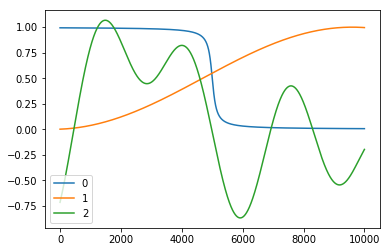

In [1142]:
sens.plot()

In [1143]:
# Factors
factor1 = pd.Series(np.random.normal(size=timespan))
factor2 = pd.Series(np.random.normal(size=timespan))
factor3 = pd.Series(np.random.normal(size=timespan))
factors = pd.concat([factor1, factor2, factor3], axis=1)

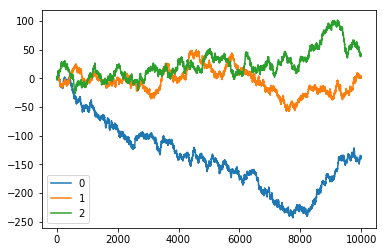

In [1144]:
factors.cumsum(axis=0).plot()

In [1145]:
# Returns
error = np.random.normal(size=timespan)*1.0
returns = pd.Series(np.multiply(factors, sens).sum(axis=1) + error)

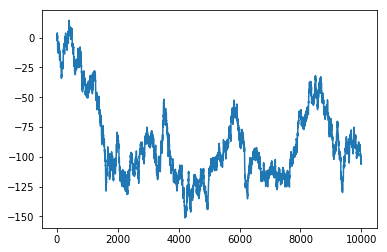

In [1146]:
returns.cumsum().plot()

## Constant regression

In [1147]:
def estimate_sensitivities_cr(factors, returns):
    reg = linear_model.LinearRegression()
    reg.fit(factors, returns)
    return pd.DataFrame(data = [reg.coef_], index = factors.index)

In [1148]:
estimated_sensitivities_cr = estimate_sensitivities_cr(factors, returns)
estimated_sensitivities_cr

,0,1,2
0,0.501189,0.525991,0.148035
1,0.501189,0.525991,0.148035
2,0.501189,0.525991,0.148035
3,0.501189,0.525991,0.148035
4,0.501189,0.525991,0.148035
5,0.501189,0.525991,0.148035
6,0.501189,0.525991,0.148035
7,0.501189,0.525991,0.148035
8,0.501189,0.525991,0.148035
9,0.501189,0.525991,0.148035


MSE for Constant OLS, assuming the factors known: 1.7125503199490089
Weighted accuracy for Constant OLS, assuming the factors known: 0.5947790041578843


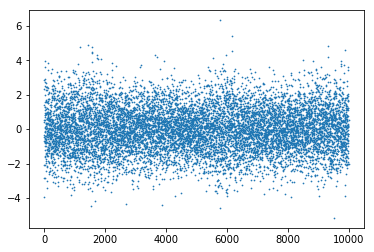

In [1149]:
plot_prediction_performance(factors, 
                            returns, 
                            estimated_sensitivities_cr, 
                            "Constant OLS")

## Rolling regression

In [1150]:
def estimate_sensitivities_rr(factors, returns, window):
    model = PandasRollingOLS(y=returns, x=factors, window=window)
    return pd.DataFrame(model.beta)

In [1151]:
window = 200
estimated_sensitivities_rr = estimate_sensitivities_rr(factors, returns, window)
estimated_sensitivities_rr

,0,1,2
199,0.988485,-0.003892,-0.537546
200,0.988664,-0.004210,-0.537951
201,0.983915,-0.019905,-0.500445
202,0.981321,-0.024735,-0.499984
203,0.991207,-0.022827,-0.499058
204,0.991958,-0.019914,-0.498150
205,0.996304,-0.017565,-0.495014
206,0.999104,-0.017405,-0.496657
207,0.998204,-0.015030,-0.498370
208,0.999043,-0.016303,-0.501608


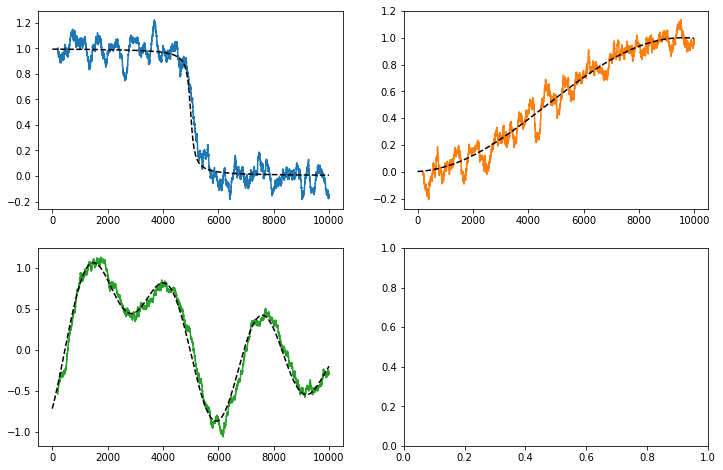

In [1152]:
plot_estimated_sensitivities(sens, estimated_sensitivities_rr, colors)

MSE for Rolling regression, assuming the factors known: 1.006330541481731
Weighted accuracy for Rolling regression, assuming the factors known: 0.8709093606078491


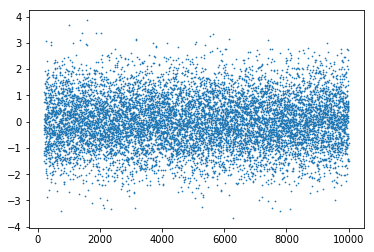

In [1153]:
plot_prediction_performance(factors.iloc[window-1:,:], 
                            returns.iloc[window-1:], 
                            estimated_sensitivities_rr, 
                            "Rolling regression")

## Weighted rolling regression

In [1154]:
# How to do that efficiently??

## Kalman filter

In [1155]:
def estimate_sensitivities_kf(factors, returns, covariance_ratio):
    n_dim_state=3
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = np.eye(3)*covariance_ratio
    observation_matrices = factors.values[:,np.newaxis,:]
    kf = KalmanFilter(initial_state_mean=[0,0,0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means)

In [1156]:
covariance_ratio = 0.0001
estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, covariance_ratio)
estimated_sensitivities_kf

,0,1,2
0,0.177246,0.091609,-0.279261
1,0.043018,0.489054,-1.168393
2,0.043490,0.440382,-1.184182
3,0.110921,0.340638,-1.290992
4,0.176204,0.241061,-1.315846
5,0.077215,0.220845,-1.293339
6,0.123571,0.218175,-1.298644
7,0.227977,0.094443,-1.122252
8,0.231741,0.090248,-1.126110
9,0.351378,0.115853,-1.099671


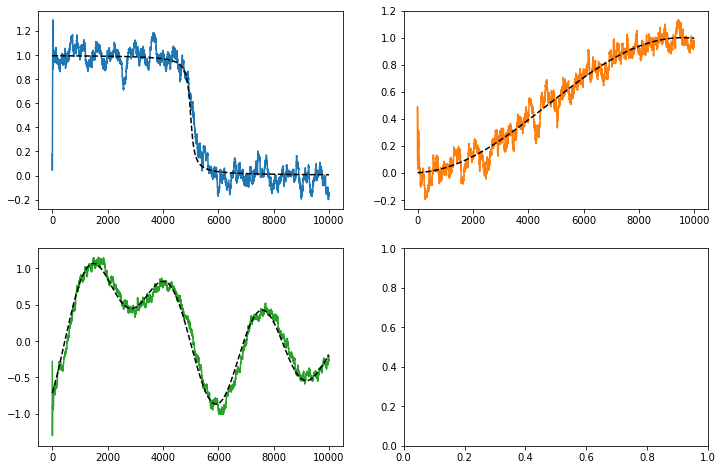

In [1157]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf, colors)

MSE for Kalman, assuming the factors known: 0.9756324733935978
Weighted accuracy for Kalman, assuming the factors known: 0.8775148430209834


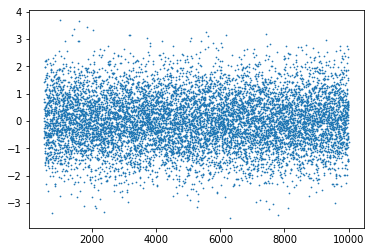

In [1158]:
burn_period = 500
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_kf.iloc[burn_period:,:], 
                            "Kalman")

In [1159]:
def estimate_sensitivities_ntc(estimated_sensitivities, trend_factor, window):
    rolling_mean = estimated_sensitivities.rolling(window, axis=0).mean()
    return (1 + trend_factor)*pd.DataFrame(estimated_sensitivities) - trend_factor*rolling_mean

In [1160]:
# Naive trend correction...
trend_factor = .5
window = 100
estimated_sensitivities_kf_ntc = estimate_sensitivities_ntc(estimated_sensitivities_kf, trend_factor, window)
estimated_sensitivities_kf_ntc
#rolling_mean = pd.DataFrame(filtered_state_means).rolling(100, axis=0).mean()
#trend_est_sens = (1 + trend_factor)*pd.DataFrame(filtered_state_means) - trend_factor*rolling_mean

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


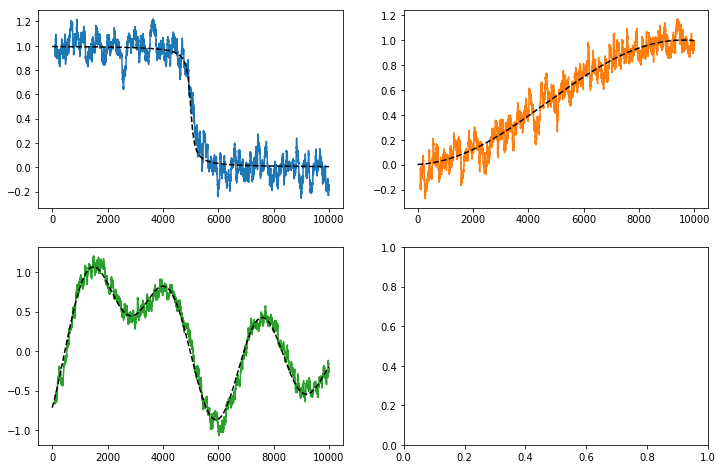

In [1161]:
plot_estimated_sensitivities(sens, estimated_sensitivities_kf_ntc, colors)

MSE for Kalman naive trend, assuming the factors known: 1.0381963504945764
Weighted accuracy for Kalman naive trend, assuming the factors known: 0.868119900351036


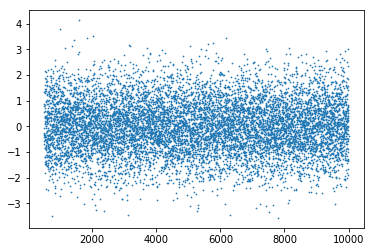

In [1162]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], returns.iloc[burn_period:], trend_est_sens.iloc[burn_period:,:], "Kalman naive trend")

## Bentz's random trend Kalman filter

In [1163]:
def estimate_sensitivities_brtkf(factors, returns, covariance_ratio):
    n_dim_state=6
    n_dim_obs=1
    observation_covariance = 1
    transition_covariance = covariance_ratio*np.eye(6)
    observation_matrices = np.array([factors.values[:, 0], 0*factors.values[:, 0],
                                     factors.values[:, 1], 0*factors.values[:, 1],
                                     factors.values[:, 2], 0*factors.values[:, 2]]).transpose()[:, np.newaxis,:]
    transition_matrix = np.kron(np.eye(3), np.array([[1, 1], [0, 1]]))
    kf = KalmanFilter(initial_state_mean=[0, 0, 0, 0, 0, 0], 
                      n_dim_state=n_dim_state, 
                      n_dim_obs=n_dim_obs, 
                      observation_matrices=observation_matrices,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance,
                      transition_matrices=transition_matrix
                     )
    filtered_state_means, filtered_state_covariances = kf.filter(returns)
    return pd.DataFrame(filtered_state_means[:,[0,2,4]])

In [1164]:
n_dim_state=6
n_dim_obs=1
observation_covariance = 1
transition_covariance = 1e-9*np.eye(6)#np.kron(np.eye(3),np.array([[1,0],[0,1]]))#
observation_matrices = np.array([factors.values[:, 0], 0*factors.values[:, 0],
                                 factors.values[:, 1], 0*factors.values[:, 1],
                                 factors.values[:, 2], 0*factors.values[:, 2]]).transpose()[:, np.newaxis,:]
transition_matrix = np.kron(np.eye(3), np.array([[1, 1], [0, 1]]))
kf = KalmanFilter(initial_state_mean=[0, 0, 0, 0, 0, 0], 
                  n_dim_state=n_dim_state, 
                  n_dim_obs=n_dim_obs, 
                  observation_matrices=observation_matrices,
                  observation_covariance=observation_covariance,
                  transition_covariance=transition_covariance,
                  transition_matrices=transition_matrix
                 )

In [1165]:
filtered_state_means, filtered_state_covariances = kf.filter(returns)
print(filtered_state_means)
filtered_state_means = pd.DataFrame(filtered_state_means[:,[0,2,4]])

[[ 1.77245517e-01  0.00000000e+00  9.16091564e-02  0.00000000e+00
  -2.79261483e-01  0.00000000e+00]
 [ 1.37065952e-01  2.87156849e-02  5.49984864e-01  2.54412907e-01
  -1.34562355e+00 -6.10077124e-01]
 [ 1.67171584e-01  2.98105047e-02  4.97599436e-01  1.29754176e-01
  -2.05812525e+00 -6.46666825e-01]
 ...
 [-1.63020958e-01 -4.14842997e-04  9.32378334e-01 -8.73499082e-05
  -2.28009966e-01  4.12194845e-04]
 [-1.82488582e-01 -4.90218702e-04  9.33570544e-01 -8.49557474e-05
  -2.14407131e-01  4.63847196e-04]
 [-1.75716303e-01 -4.62222100e-04  9.24365001e-01 -1.20131318e-04
  -2.13516762e-01  4.66258782e-04]]


In [1166]:
estimated_sensitivities_brtkf = estimate_sensitivities_brtkf(factors, returns, 1e-9)
estimated_sensitivities_brtkf

,0,1,2
0,0.177246,0.091609,-0.279261
1,0.137066,0.549985,-1.345624
2,0.167172,0.497599,-2.058125
3,-0.283741,0.752099,-2.156791
4,0.023619,0.514851,-2.300621
5,-1.726892,0.091825,-2.441391
6,-1.945022,-0.007334,-2.713481
7,-0.546951,-0.652642,-1.187882
8,-0.113648,-0.607338,-0.867460
9,0.954627,-0.433347,-0.353610


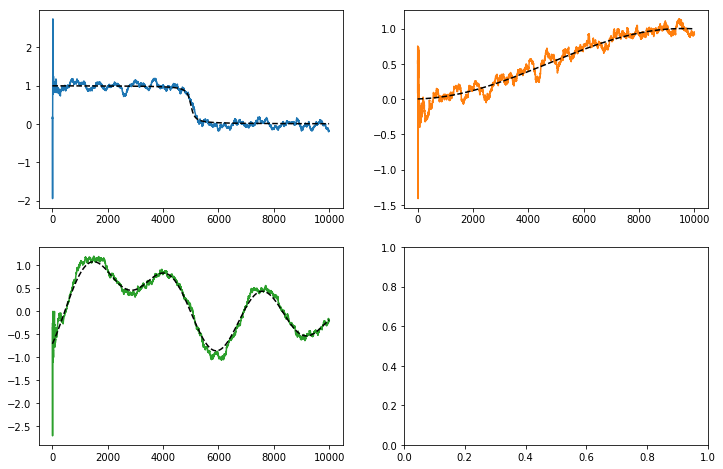

In [1167]:
plot_estimated_sensitivities(sens, estimated_sensitivities_brtkf, colors)

MSE for Kalman Bentz trend, assuming the factors known: 0.9855531688320267
Weighted accuracy for Kalman Bentz trend, assuming the factors known: 0.8806263051085502


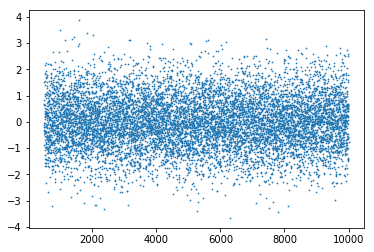

In [1168]:
burn_period = 500#window
plot_prediction_performance(factors.iloc[burn_period:,:], 
                            returns.iloc[burn_period:], 
                            estimated_sensitivities_brtkf.iloc[burn_period:,:], 
                            "Kalman Bentz trend")

## Performance summary

In [1169]:
pd.Series(performance_record_mse)

Constant OLS          1.712550
Rolling regression    1.006331
Kalman                0.975632
Kalman naive trend    1.038196
Kalman Bentz trend    0.985553
dtype: float64

In [1170]:
pd.Series(performance_record_wacc)

Constant OLS          0.594779
Rolling regression    0.870909
Kalman                0.877515
Kalman naive trend    0.868120
Kalman Bentz trend    0.880626
dtype: float64

## Systematic analysis

We want to run the experiment above a large number of times to gather statistics on the performance of the regression estimators.

In [1210]:
def estimate_regression_performance(factors, returns, name, performance_record_mse, performance_record_wacc):
    burn_period = 500
    if name == "Constant OLS":
        start_time = 0
        estimated_sensitivities = estimate_sensitivities_cr(factors, returns)
    elif name == "Rolling OLS":
        start_time = 199
        estimated_sensitivities = estimate_sensitivities_rr(factors, returns, 200)
    elif name == "Kalman":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_kf(factors, returns, 1e-4)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name == "Kalman naive trend":
        start_time = burn_period
        estimated_sensitivities_kf = estimate_sensitivities_kf(factors, returns, 1e-4)
        estimated_sensitivities = estimate_sensitivities_ntc(estimated_sensitivities_kf, 0.5, 100)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    elif name == "Kalman Bentz trend":
        start_time = burn_period
        estimated_sensitivities = estimate_sensitivities_brtkf(factors, returns, 1e-9)
        estimated_sensitivities = estimated_sensitivities.iloc[start_time:,:]
    else:
        print("Unknown name")
    estimated_returns = compute_estimated_returns(factors.iloc[start_time:,:], estimated_sensitivities)
    print_mse_performance(estimated_returns, 
                          returns.iloc[start_time:], 
                          name, 
                          performance_record_mse,
                          verbose=False)
    print_weighted_accuracy_performance(estimated_returns, 
                                        returns.iloc[start_time:], 
                                        name, 
                                        performance_record_wacc,
                                        verbose=False)    

def get_performance_data(num_samples):
    performance_record_mse = {}
    performance_record_wacc = {}
    list_performance_record_mse = []
    list_performance_record_wacc = []
    
    for i in range(num_samples):
        print(i)
        # Factors
        factor1 = pd.Series(np.random.normal(size=timespan))
        factor2 = pd.Series(np.random.normal(size=timespan))
        factor3 = pd.Series(np.random.normal(size=timespan))
        factors = pd.concat([factor1, factor2, factor3], axis=1)
        
        # Returns
        error = np.random.normal(size=timespan)*1.0
        returns = pd.Series(np.multiply(factors, sens).sum(axis=1) + error)
                
        estimate_regression_performance(factors, returns, "Constant OLS", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Rolling OLS", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Kalman", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Kalman naive trend", 
                                        performance_record_mse, performance_record_wacc)
        estimate_regression_performance(factors, returns, "Kalman Bentz trend", 
                                        performance_record_mse, performance_record_wacc)
        
        list_performance_record_mse.append(performance_record_mse.copy())
        list_performance_record_wacc.append(performance_record_wacc.copy())
        performance_record_mse = {}
        performance_record_wacc = {}
        
    return pd.DataFrame(list_performance_record_mse), pd.DataFrame(list_performance_record_wacc)

In [1211]:
num_samples = 100
performance_record_mse_new, performance_record_wacc_new = get_performance_data(num_samples)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1214]:
performance_record_mse.describe()

,Constant OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.671884,0.963837,0.973810,0.939258,0.992898
std,0.022389,0.013841,0.014075,0.013553,0.014352
min,1.630568,0.938409,0.947417,0.914356,0.966211
25%,1.654271,0.952830,0.962454,0.928547,0.982452
50%,1.669780,0.963451,0.973095,0.938319,0.991559
75%,1.687783,0.972480,0.982897,0.947989,1.001308
max,1.748007,1.003988,1.014711,0.978088,1.039251


In [1215]:
performance_record_wacc.describe()

,Constant OLS,Kalman,Kalman Bentz trend,Kalman naive trend,Rolling OLS
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.595228,0.882924,0.880505,0.889508,0.873795
std,0.015107,0.012941,0.012956,0.012546,0.012574
min,0.555706,0.848894,0.850605,0.858236,0.843940
25%,0.583313,0.875359,0.872709,0.882567,0.865767
50%,0.594805,0.882107,0.880847,0.889261,0.873249
75%,0.607239,0.891087,0.888405,0.898598,0.881417
max,0.627948,0.909513,0.908084,0.916023,0.902391


In [1226]:
performance_record_wacc.std()/np.sqrt(len(performance_record_wacc))

Constant OLS          0.001511
Kalman                0.001294
Kalman Bentz trend    0.001296
Kalman naive trend    0.001255
Rolling OLS           0.001257
dtype: float64

In [1229]:
(performance_record_wacc.mean() - performance_record_wacc['Rolling OLS'].mean()).divide(performance_record_wacc.std()/np.sqrt(len(performance_record_wacc)))

Constant OLS         -184.401540
Kalman                  7.055161
Kalman Bentz trend      5.179143
Kalman naive trend     12.524218
Rolling OLS             0.000000
dtype: float64

In [1230]:
(performance_record_mse.mean() - performance_record_mse['Rolling OLS'].mean()).divide(performance_record_mse.std()/np.sqrt(len(performance_record_mse)))

Constant OLS          303.270934
Kalman                -20.995945
Kalman Bentz trend    -13.562073
Kalman naive trend    -39.578310
Rolling OLS             0.000000
dtype: float64

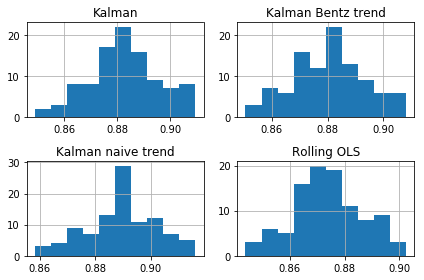

In [1237]:
performance_record_wacc.iloc[:,1:].hist(layout=(2, 2))
plt.tight_layout()

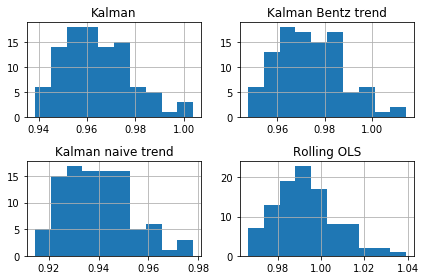

In [1238]:
performance_record_mse.iloc[:,1:].hist(layout=(2, 2))
plt.tight_layout()